# Week 5

This week, we continue improving neural networks by considering two different issues:

* Overfitting -- when we get high training accuracy, but low testing accuracy (poor generalization)
* Convergence -- getting our network to actually shrink the loss function and get good training accuracy

# Lecture 9 - Sept 21 - Overfitting and Regularization

Any approach meant to improve overfitting is referred to as **regularization**. There are many approaches we will discuss, although we will not implement them all this week:

* $L^1$ regularization
* $L^2$ regularization
* Dropout
* Adjusting the net architecture
* Early stopping
* Gathering more data
* Artificially generating more data

## L1 and L2 Regularization

We have encountered two forms of regularization in the previous weeks in the context of linear regression: $L^1$ and $L^2$ penalties, where we add some extra terms to the loss function that aim to pressure the parameters into not growing too large, which tends to improve testing results.

### L1 Regularization

To remind you what $L^1$ regularizatoin is, a loss function with $L^1$ regularization would be in the form

$$L(\text{weights}) = L_0(\text{weights}) + \frac{\lambda_1}{n}\sum\limits_w |w|$$

where $L_0$ is the loss function without $L^1$ regularization. So, we add a constant times the sum of the absolute values of all the weights. This change in loss function means there will be a corresponding change in the gradient of the loss function, which we use to allow gradient descent make weight updates.

If $w>0$, the derivative of $|w|=w$ is 1. If $w<0$, the derivative of $|w|=-w$ is -1. At $w=0$, the derivative does not exist, but we will use the convention of setting it equal to 0. So, then, the derivative of the regularization term $\frac{\lambda_1}{2n}w$ for each weight is $\frac{\lambda_2}{n}\text{sign}(w)$. Therefore, the partial derivative of the loss function $L$ with respect to a weight $w$ is

$$\frac{\partial L(\text{weights})}{\partial w} = \frac{\partial L_0(\text{weights})}{\partial w} + \frac{\lambda_1}{n}\text{sign}(w)$$

### L2 Regularization

To remind you what $L^2$ regularizatoin is, a loss function with $L^2$ regularization would be in the form

$$L(\text{weights}) = L_0(\text{weights}) + \frac{\lambda_2}{2n}\sum\limits_w w^2$$

where $L_0$ is the loss function without $L^2$ regularization. So, we add a constant times the sum of the squares of all the weights. This change in loss function means there will be a corresponding change in the gradient of the loss function, which we use to allow gradient descent make weight updates.

The derivative of $\frac{\lambda_2}{2n}w^2$ is $\frac{\lambda_2}{n} w$, so then, the partial derivative of the loss function $L$ with respect to a weight $w$ is

$$\frac{\partial L(\text{weights})}{\partial w} = \frac{\partial L_0(\text{weights})}{\partial w} + \frac{\lambda_2}{n} w$$

### Implementing L1 and L2 Regularization

Below is a class including all the pieces we have constructed in class so far:

* Stochastic gradient descent with customizable mini-batch size
* Two loss functions
* Periodic status updates on loss, training accuracy, and testing accuracy
* Plots of loss, training accuracy, and testing accuracy computed periodically

along with $L^1$ and $L^2$ penalties.

Let's import some libraries.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import warnings

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [4]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient
#
#   lambda2 - L2 penalty coefficient
#
#   batchSize - size of mini-batches for SGD
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # loss function
        self.loss = loss
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1)/100.0)
            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1])/100.0)
        
    # define the activation function
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the activation derivative (where x is the INPUT to activation function)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = to_categorical(y)

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.sigmoid(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.sigmoidDerivative(A[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.sigmoidDerivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * (A[layer].T.dot(D[layer])
                                                   + 2 * (self.lambda2 / numberOfExamples) * self.W[layer]
                                                   + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer]) * self.W[layer])

            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                
                # compute the loss
                loss = self.computeLoss(X,y)

                # if we choose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    print('Epoch =', epoch + 1, 'loss = ', loss)

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.sigmoid(np.dot(p, self.W[layer]))
            
        # return the predictions
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        
        # initialize data to the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
        
        # add L1 and L2 penalty
        L1penalty = 0
        L2penalty = 0
        
        # add up L1 and L2 penalties from each layer
        for layer in np.arange(0,len(self.W)):
            L1penalty += np.sum(np.abs(self.W[layer]))
            L2penalty += np.sum(self.W[layer] ** 2)
        
        # L1 and L2 penalties to the loss
        loss += (self.lambda1 / X.shape[0]) * L1penalty
        loss += (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

### Testing L1 and L2 Regularization

Let's run it on MNIST without regularization just to see that the code works.

In [ ]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.01, 0.0, 0.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

In [2]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.05, 0.0, 0.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

NameError: name 'mnist' is not defined

Let's add L2 penalty

Test set accuracy
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.96      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.98      0.95      0.96      1010
           4       0.95      0.97      0.96       982
           5       0.95      0.95      0.95       892
           6       0.97      0.97      0.97       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



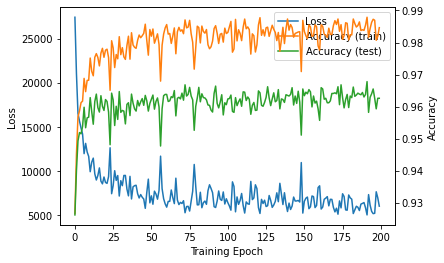

In [36]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.05, 0.0, 10.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

That worked, so let's try some more

Test set accuracy
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.97      0.96       982
           5       0.98      0.93      0.95       892
           6       0.98      0.97      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.95      0.96      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



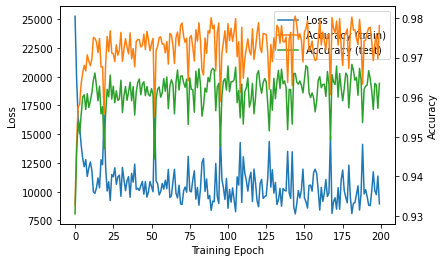

In [37]:
# load the full MNIST dataset: both data and labels
((trainX, trainY), (testX, testY)) = mnist.load_data()

# scale the data to values in [0,1]
trainX = trainX.astype('float32')/255.0
testX = testX.astype('float32')/255.0

# reshape the data
trainX = trainX.reshape([60000, 28*28])
testX = testX.reshape([10000, 28*28])

# fit the model to the training data
model = FeedforwardNeuralNetwork([784, 32, 16, 10], 0.05, 0.0, 50.0, 32, 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

$\lambda_2=50.0$ seemed to be too much, as performance declined from $\lambda_2=10.0$.